In [9]:
import numpy as np
import glob
import os
%matplotlib inline
from readTRC import readTrc
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chisquare
import numpy.polynomial.polynomial as poly

In [10]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [11]:
def FILE_SORTER(files):
    FilesGold   = []
    FilesSignal = []
    for x in range(0,len(files)):
        if int(files[x][1]) ==3:
            FilesGold.append(files[x])
        if int(files[x][1]) ==2:
            FilesSignal.append(files[x])
            
    FilesGold.sort(); FilesSignal.sort()
    return FilesGold, FilesSignal

def MEAN_WAVEFORM(PATH,files):
    #folders[F]+FilesSignal[0]
    #X, Y, info = readTrc(PATH+files[10])
    #Yvals = np.zeros(X.shape[0])
    #Xvals = np.zeros(Y.shape[0])
    Yvals = np.zeros(500002)
    Xvals = np.zeros(500002)
    avg = 0
    for w in range(0,len(files)):

        X, Y, info = readTrc(PATH+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    MSigY = Yvals/avg
    MSigX = Xvals/avg
    return MSigX,MSigY

def WAVEFORM_QUALITY(PATH,files,MEAN,CHI):
    
    #X, Y, info = readTrc(PATH+files[10])
    #Yvals = np.zeros(X.shape[0])
    #Xvals = np.zeros(Y.shape[0])
    Yvals = np.zeros(500002)
    Xvals = np.zeros(500002)
    avg = 0
    #for w in range(0,1100):
    CHII = []
    for w in range(0,len(files)):

        X, Y, info = readTrc(PATH+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            A = moving_average(MEAN,10)
            B = moving_average(Y   ,10)
            D = moving_average(X   ,10)
            TriggerTime = find_nearest(D,0)
            Trigger     = np.where(D==TriggerTime)[0][0]
            As    = np.mean(A[:Trigger])
            Bs    = np.mean(B[:Trigger])
            
            holder = ((A-As)-(B-Bs))**2
            chi = np.sum(holder)*1e4
            if chi <CHI:
                Yvals += Y
                Xvals += X
                avg   += 1
                CHII.append(chi)
        if avg != 0:
            SigY = Yvals/avg
            SigX = Xvals/avg
        else:
            SigY = Yvals
            SigX = Xvals 
        
    #CHI=np.array(CHI)
    return SigX,SigY,CHII

In [12]:
FOLD = ['100/']
FOLD = ['000/']
FOLD = ['010/']
FOLD = ["090/"]

PATH = '/Volumes/MY PASSPORT/HeliumXenonV3/'+FOLD[0]
SPATH = '/Users/austinmcdonald/Desktop/HeliumXenon/'+FOLD[0]
folders = glob.glob(PATH+"*/")
folders.sort()
folders[-3]

'/Volumes/MY PASSPORT/HeliumXenonV3/090/Xe-090_P-09_E-200/'

In [16]:
ChG = []
ChS = []
for per in range(0,len(FOLD)):

    #SPATH = '/Users/austinmcdonald/Desktop/Ele-Ar-text/Data/'+FOLD[per]
    #PATH = '/Users/austinmcdonald/Desktop/Ele-Ar-text/'+FOLD[per]
    PATH = '/Volumes/MY PASSPORT/HeliumXenonV3/'+FOLD[per]
    #SPATH = '/Users/austinmcdonald/Desktop/HeliumXenon/'+FOLD[per]
    folders = glob.glob(PATH+"*/")
    folders.sort()
    #folders = folders[-2]
    
    CHI = 100
    for F in range(0,len(folders)):
    #for F in [0]:
        NAME = folders[F].split('/')[-2]
        print(NAME)
        files = os.listdir(folders[F])
        if '.DS_Store' in files: files.remove('.DS_Store')

        FG,FS = FILE_SORTER(files)
        Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
        Gx,Gy,ChiG = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)

        Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
        Sx,Sy,ChiS = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
        ChG.append(ChiG)
        ChS.append(ChiS)
        TriggerTime  = find_nearest(Sx,0)
        Trigger      = np.where(Sx==TriggerTime)[0][0]
        baselineS    = np.mean(Sy[0:Trigger])
        baselineG    = np.mean(Gy[0:Trigger])
        data = [Gx, Gy-baselineG, Sy-baselineS]
        #np.savetxt(SPATH+NAME+'.txt',data)

Xe-090_P-01_E-100


KeyboardInterrupt: 

In [20]:
ChG = []
ChS = []
for per in range(0,len(FOLD)):

    #SPATH = '/Users/austinmcdonald/Desktop/Ele-Ar-text/Data/'+FOLD[per]
    #PATH = '/Users/austinmcdonald/Desktop/Ele-Ar-text/'+FOLD[per]
    PATH = '/Volumes/MY PASSPORT/HeliumXenonV3/'+FOLD[per]
    #SPATH = '/Users/austinmcdonald/Desktop/HeliumXenon/'+FOLD[per]
    folders = glob.glob(PATH+"*/")
    folders.sort()
    #folders = folders[-2]
    
    CHI = 100000
    #for F in range(0,len(folders)):
    for F in [-3]:
        NAME = folders[F].split('/')[-2]
        print(NAME)
        files = os.listdir(folders[F])
        if '.DS_Store' in files: files.remove('.DS_Store')

        FG,FS = FILE_SORTER(files)
        Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
        Gx,Gy,ChiG = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)

        Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
        Sx,Sy,ChiS = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
        ChG.append(ChiG)
        ChS.append(ChiS)
        TriggerTime  = find_nearest(Sx,0)
        Trigger      = np.where(Sx==TriggerTime)[0][0]
        baselineS    = np.mean(Sy[0:Trigger])
        baselineG    = np.mean(Gy[0:Trigger])
        data = [Gx, Gy-baselineG, Sy-baselineS]
        #np.savetxt(SPATH+NAME+'.txt',data)

Xe-090_P-09_E-200


(array([746., 147.,  62.,  23.,  11.,   7.,   2.,   1.,   0.,   2.]),
 array([ 13.02918847,  43.0073319 ,  72.98547533, 102.96361877,
        132.9417622 , 162.91990564, 192.89804907, 222.8761925 ,
        252.85433594, 282.83247937, 312.81062281]),
 <a list of 10 Patch objects>)

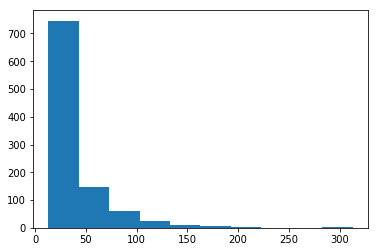

In [21]:
plt.hist(ChS)